### Cap 1

#### Introdução e Contextualização

O dataset escolhido para este trabalho é o [Global Coffee Health Dataset](https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset).

O café é uma das bebidas mais consumidas globalmente, com profundo impacto econômico, cultural e na saúde pública. Estudos recentes demonstram que o consumo moderado de café está associado a benefícios significativos para a saúde, incluindo redução do risco de mortalidade por todas as causas, doenças cardiovasculares, certos tipos de câncer e condições metabólicas e hepáticas . No entanto, esses efeitos podem variar conforme fatores como genética, métodos de preparo e hábitos de consumo.

O Global Coffee Health Dataset, disponibilizado publicamente no Kaggle, foi criado para agregar dados heterogêneos relacionados ao consumo de café e seus efeitos na saúde. Este dataset permite análises padronizadas e a aplicação de técnicas de aprendizado de máquina para identificar padrões complexos entre variáveis socioculturais, comportamentais e clínicas.

#### Descrição do Dataset

O dataset escolhido é do tipo tabular, consistindo de um total de 10000 amostras. Cada amostra é composta por dados referentes à indivíduos participantes na pesquisa desenvolvida para compor o dataset. Os atributos disponíveis são:

|Nome do atributo|Tipo de dado|Descrição|
|---|---|---|
|ID|Inteiro|Identificador único para cada amostra.|
|Age|Inteiro|Idade dos participantes.|
|Gender|Categórico|O gênero dos participantes.|
|Country|Categórico|País de residência dos participantes.|	
|Coffee_Intake|Numérico|Copos de café consumidos diariamente.|
|Caffeine_mg|Numérico|Consumo estimado em mg de cafeína (considerando 1 copo = 95mg).|
|Sleep_Hours|Numérico|Média de horas de sono por noite.|
|Sleep_Quality|Categórico|Indicador da qualidade do sono (baseado em Sleep_Hours).|
|BMI|Numérico|O índice de massa corporal dos participantes.|
|Heart_Rate|Inteiro|Batimentos cardíacos em repouso.|
|Stress_Level|Categórico|Indicador do nível de estresse.|
|Physical_Activity_Hours|Numérico|Horas de atividade física por semana.|
|Health_Issues|Categórico|Indicador do grau de problemas de saúde dos participantes.|
|Occupation|Categórico|Profissão dos participantes.|
|Smoking|Booleano|Indicador se os participantes fumam (1) ou não (0).|
|Alcohol_Consumption|Booleano|Indicador se os participantes consomen álcool (1) ou não (0).|

Para este trabalho, a coluna `Health_Issues` será tratada como a coluna classificadora, sendo seus valores (None, Mild, Moderate, Severe) as classes.


### Cap 2  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
import numpy as np

In [2]:
df = pd.read_csv('../synthetic_coffee_health_10000.csv')

df['Health_Issues'] = df['Health_Issues'].fillna('None')

# 2.1 Espaço amostral
total_dataset_samples = len(df)
classes = df['Health_Issues'].unique()

print(f"Total samples in Dataset: {total_dataset_samples}")
print(f"Different Classes in Dataset: {classes}")

Total samples in Dataset: 10000
Different Classes in Dataset: ['None' 'Mild' 'Moderate' 'Severe']


In [3]:
# 2.2 Probabilidades dos resultados possíveis

none_samples = df['Health_Issues'].value_counts()['None']
mild_samples = df['Health_Issues'].value_counts()['Mild']
moderate_samples = df['Health_Issues'].value_counts()['Moderate']
severe_samples = df['Health_Issues'].value_counts()['Severe']

print(f"Total None Health Issues samples: {none_samples}")
print(f"Total Mild Health Issues samples: {mild_samples}")
print(f"Total Moderate Health Issues samples: {moderate_samples}")
print(f"Total Severe Health Issues samples: {severe_samples}\n")

prob_None = none_samples / total_dataset_samples
prob_Mild = mild_samples / total_dataset_samples
prob_Moderate = moderate_samples / total_dataset_samples
prob_Severe = severe_samples / total_dataset_samples

print(f"Probability of None Health Issues: {prob_None}")
print(f"Probability of Mild Health Issues: {prob_Mild}")
print(f"Probability of Moderate Health Issues: {prob_Moderate}")
print(f"Probability of Severe Health Issues: {prob_Severe}")

Total None Health Issues samples: 5941
Total Mild Health Issues samples: 3579
Total Moderate Health Issues samples: 463
Total Severe Health Issues samples: 17

Probability of None Health Issues: 0.5941
Probability of Mild Health Issues: 0.3579
Probability of Moderate Health Issues: 0.0463
Probability of Severe Health Issues: 0.0017


In [4]:
# 2.3 Definição de 3 eventos e suas probabilidades
# Evento 1 - Participantes que bebem
# Evento 2 - Participantes que fumam
# Evento 3 - Participantes que não dormem bem (Sleep_Quality = Poor)

c_event1 = df['Alcohol_Consumption'].value_counts()[1]
c_event2 = df['Smoking'].value_counts()[1]
c_event3 = df['Sleep_Quality'].value_counts()['Poor']

print(f"Total Drinking samples: {c_event1}")
print(f"Total Smoking samples: {c_event2}")
print(f"Total Poor Sleep samples: {c_event3}")

prob_event1 = c_event1 / total_dataset_samples
prob_event2 = c_event2 / total_dataset_samples
prob_event3 = c_event3 / total_dataset_samples

print(f"Probability of Event 1: {prob_event1}")
print(f"Probability of Event 2: {prob_event2}")
print(f"Probability of Event 3: {prob_event3}")

Total Drinking samples: 3007
Total Smoking samples: 2004
Total Poor Sleep samples: 961
Probability of Event 1: 0.3007
Probability of Event 2: 0.2004
Probability of Event 3: 0.0961


In [5]:
# 2.4 Descrever/Comente como a escolha das características (eventos) diferentes modificaram (ou não) os resultados
events = {
    "Event 1": df['Alcohol_Consumption'] == 1,
    "Event 2": df['Smoking'] == 1,
    "Event 3": df['Sleep_Quality'] == 'Poor'
}

conditional_probs = {}
for event_name, condition in events.items():
    event_data = df[condition]
    total_event = len(event_data)
    cond_probs = []
    for cls in classes:
        count_cls = len(event_data[event_data['Health_Issues'] == cls])
        cond_prob = count_cls / total_event
        cond_probs.append(cond_prob)
    conditional_probs[event_name] = cond_probs

# Comparação com probabilidades a priori
prior_probs = [prob_None, prob_Mild, prob_Moderate, prob_Severe]

for event_name, cond_probs in conditional_probs.items():
    print(f"\n{event_name}:")
    for cls, prior, cond in zip(classes, prior_probs, cond_probs):
        ratio = cond / prior
        print(f"  {cls}: Prior = {prior:.4f}, Condicional = {cond:.4f}, Ratio = {ratio:.2f}")


Event 1:
  None: Prior = 0.5941, Condicional = 0.6019, Ratio = 1.01
  Mild: Prior = 0.3579, Condicional = 0.3528, Ratio = 0.99
  Moderate: Prior = 0.0463, Condicional = 0.0442, Ratio = 0.96
  Severe: Prior = 0.0017, Condicional = 0.0010, Ratio = 0.59

Event 2:
  None: Prior = 0.5941, Condicional = 0.6018, Ratio = 1.01
  Mild: Prior = 0.3579, Condicional = 0.3433, Ratio = 0.96
  Moderate: Prior = 0.0463, Condicional = 0.0529, Ratio = 1.14
  Severe: Prior = 0.0017, Condicional = 0.0020, Ratio = 1.17

Event 3:
  None: Prior = 0.5941, Condicional = 0.0000, Ratio = 0.00
  Mild: Prior = 0.3579, Condicional = 0.8470, Ratio = 2.37
  Moderate: Prior = 0.0463, Condicional = 0.1498, Ratio = 3.24
  Severe: Prior = 0.0017, Condicional = 0.0031, Ratio = 1.84


In [6]:
# 2.5 União de probabilidades
prob_event1_or_event2 = len(df[(df['Alcohol_Consumption'] == 1) | (df['Smoking'] == 1)]) / total_dataset_samples
prob_event1_or_event3 = len(df[(df['Alcohol_Consumption'] == 1) | (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples
prob_event2_or_event3 = len(df[(df['Smoking'] == 1) | (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples

print(f"P(Event1 ∪ Event2): {prob_event1_or_event2}")
print(f"P(Event1 ∪ Event3): {prob_event1_or_event3}")
print(f"P(Event2 ∪ Event3): {prob_event2_or_event3}")

P(Event1 ∪ Event2): 0.443
P(Event1 ∪ Event3): 0.3678
P(Event2 ∪ Event3): 0.2788


In [7]:
# 2.6 Interseção de probabilidades
prob_event1_and_event2 = len(df[(df['Alcohol_Consumption'] == 1) & (df['Smoking'] == 1)]) / total_dataset_samples
prob_event1_and_event3 = len(df[(df['Alcohol_Consumption'] == 1) & (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples
prob_event2_and_event3 = len(df[(df['Smoking'] == 1) & (df['Sleep_Quality'] == 'Poor')]) / total_dataset_samples

print(f"P(Event1 ∩ Event2): {prob_event1_and_event2}")
print(f"P(Event1 ∩ Event3): {prob_event1_and_event3}")
print(f"P(Event2 ∩ Event3): {prob_event2_and_event3}")

P(Event1 ∩ Event2): 0.0581
P(Event1 ∩ Event3): 0.029
P(Event2 ∩ Event3): 0.0177


In [8]:
# 2.7 Defina 3 exemplos de probabilidades condicionais
# EventoC 1 - Problema de saúde dado que fuma
# EventoC 2 - Sem problema de saúde dado que sono excelente
# EventoC 3 - Problema de saúde dado que estresse alto ou pouca qualidade de sono

p_eventc1 = (
    len(df[(df['Smoking'] == 1) & (df['Health_Issues'] != 'None')]) / 
    len(df[df['Smoking'] == 1])
)
p_eventc2 = (
    len(df[(df['Sleep_Quality'] == 'Excellent') & (df['Health_Issues'] == 'None')]) /
    len(df[df['Sleep_Quality'] == 'Excellent'])
)

p_eventc3 = (
    len(df[((df['Stress_Level'] == 'High') | (df['Sleep_Quality'] == 'Poor')) & (df['Health_Issues'] != 'None')]) /
    len(df[(df['Stress_Level'] == 'High') | (df['Sleep_Quality'] == 'Poor')])
)

print(f"P(EventC1): {p_eventc1}")
print(f"P(EventC2): {p_eventc2}")
print(f"P(EventC3): {p_eventc3}")


P(EventC1): 0.39820359281437123
P(EventC2): 0.8357988165680473
P(EventC3): 1.0


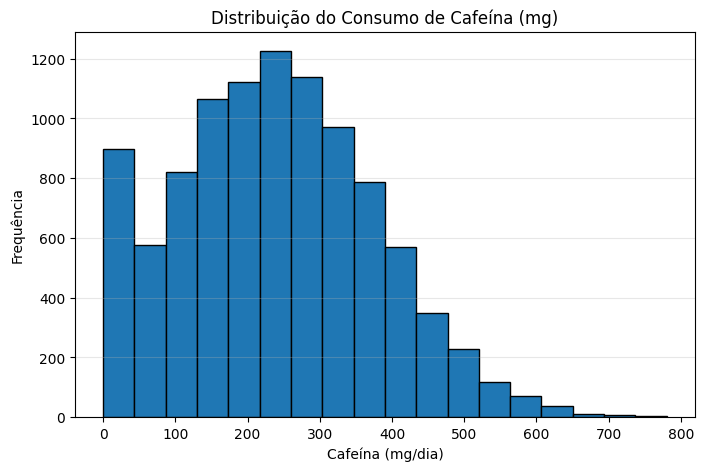

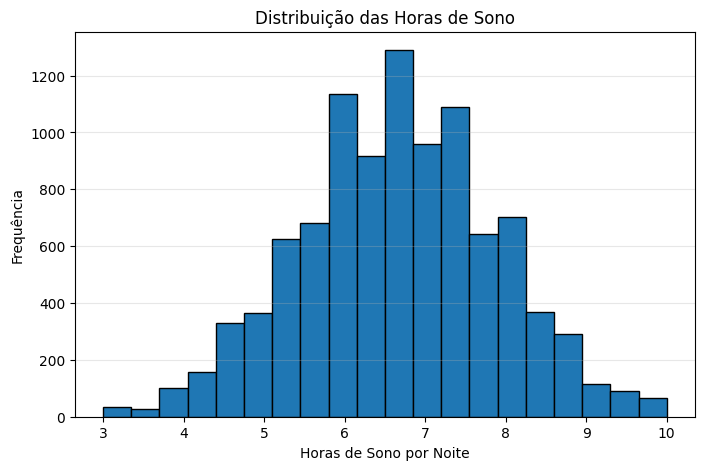

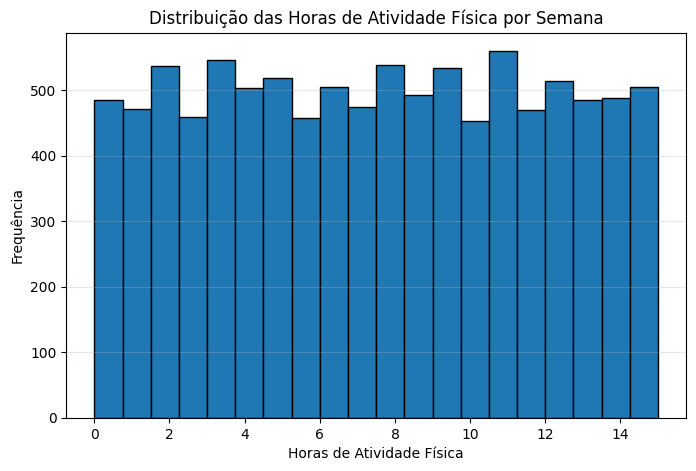

C:\Users\Walmir\AppData\Local\Temp\ipykernel_4180\3435054995.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ordered_data, labels=class_order)


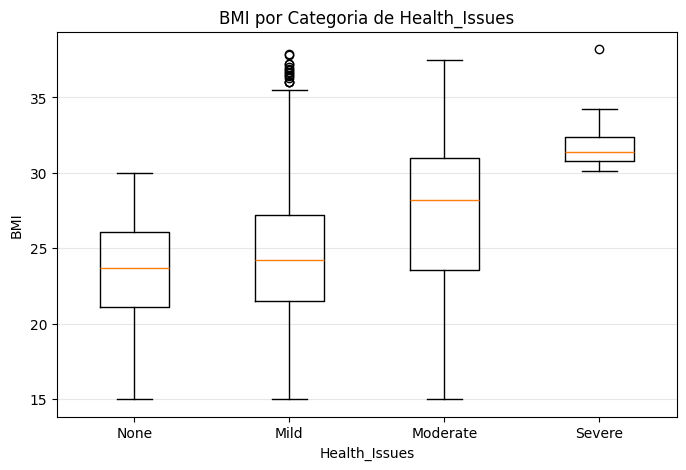

C:\Users\Walmir\AppData\Local\Temp\ipykernel_4180\3435054995.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ordered_data, labels=class_order)


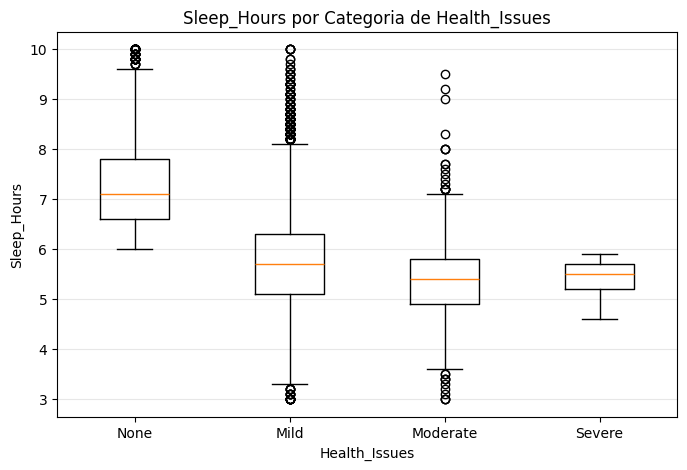

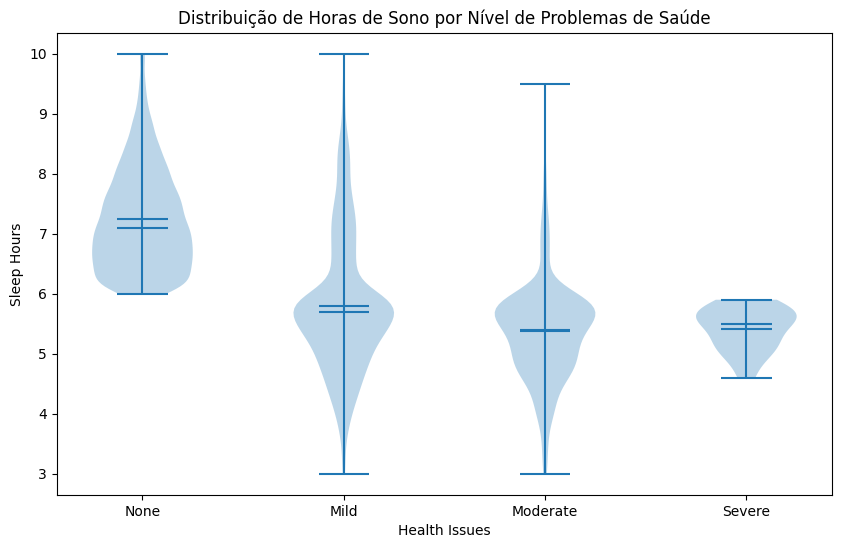

In [9]:
# --- Histogramas de partições ---
# Consumo de Cafeína (mg)
plt.figure(figsize=(8, 5))
plt.hist(df['Caffeine_mg'], bins=18, edgecolor='black')
plt.title('Distribuição do Consumo de Cafeína (mg)')
plt.xlabel('Cafeína (mg/dia)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Horas de Sono
plt.figure(figsize=(8, 5))
plt.hist(df['Sleep_Hours'], bins=20, edgecolor='black')
plt.title('Distribuição das Horas de Sono')
plt.xlabel('Horas de Sono por Noite')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Atividade Física
plt.figure(figsize=(8, 5))
plt.hist(df['Physical_Activity_Hours'], bins=20, edgecolor='black')
plt.title('Distribuição das Horas de Atividade Física por Semana')
plt.xlabel('Horas de Atividade Física')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- Boxplots por classe de Health_Issues ---
features = ['BMI', 'Sleep_Hours']
class_order = ['None', 'Mild', 'Moderate', 'Severe']

for feature in features:
    plt.figure(figsize=(8, 5))
    ordered_data = [df[df['Health_Issues'] == cls][feature].dropna() for cls in class_order]
    plt.boxplot(ordered_data, labels=class_order)
    plt.title(f'{feature} por Categoria de Health_Issues')
    plt.xlabel('Health_Issues')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Supondo que df seja seu DataFrame
fig, ax = plt.subplots(figsize=(10, 6))
violin = ax.violinplot(
    [df[df['Health_Issues'] == cat]['Sleep_Hours'] for cat in ['None', 'Mild', 'Moderate', 'Severe']],
    showmeans=True,
    showmedians=True
)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['None', 'Mild', 'Moderate', 'Severe'])
ax.set_xlabel('Health Issues')
ax.set_ylabel('Sleep Hours')
ax.set_title('Distribuição de Horas de Sono por Nível de Problemas de Saúde')
plt.show()


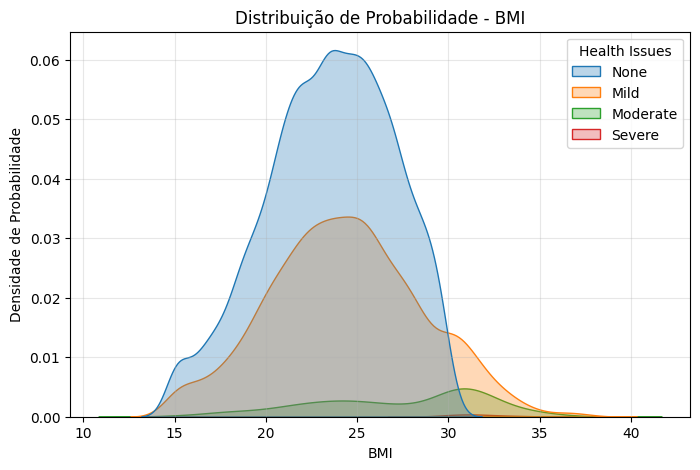

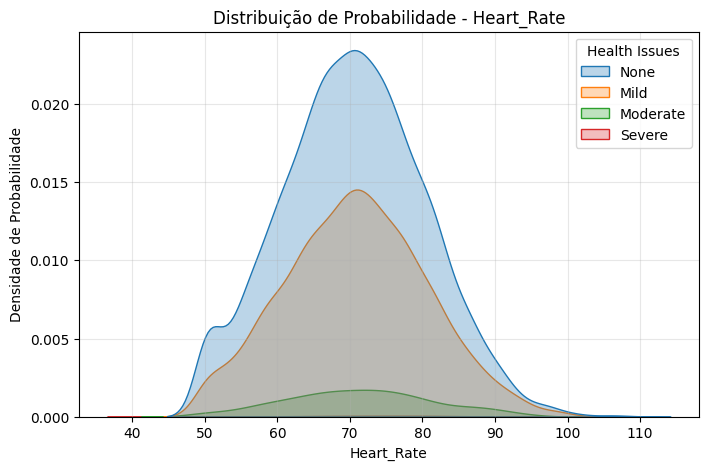

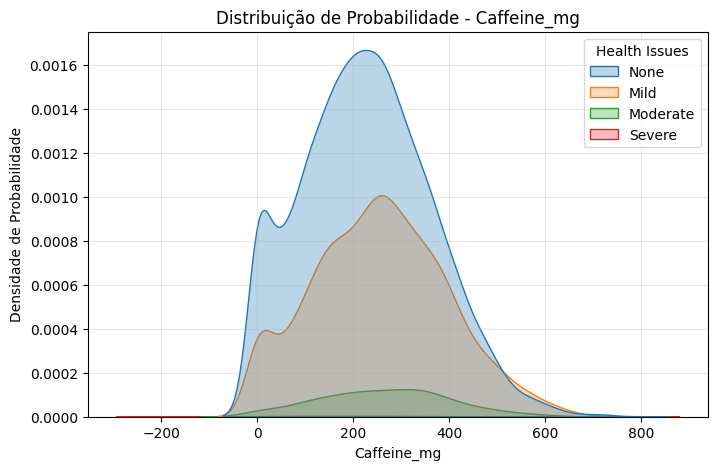

In [10]:
# 2.9 Aplicar FDP
features = ['BMI', 'Heart_Rate', 'Caffeine_mg']

for feature in features:
    plt.figure(figsize=(8, 5))
    
    ax = sns.kdeplot(data=df, x=feature, hue='Health_Issues', fill=True, alpha=0.3)
    
    plt.title(f'Distribuição de Probabilidade - {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidade de Probabilidade')
    
    if ax.get_legend():
        ax.get_legend().set_title('Health Issues')
    
    plt.grid(alpha=0.3)
    plt.show()

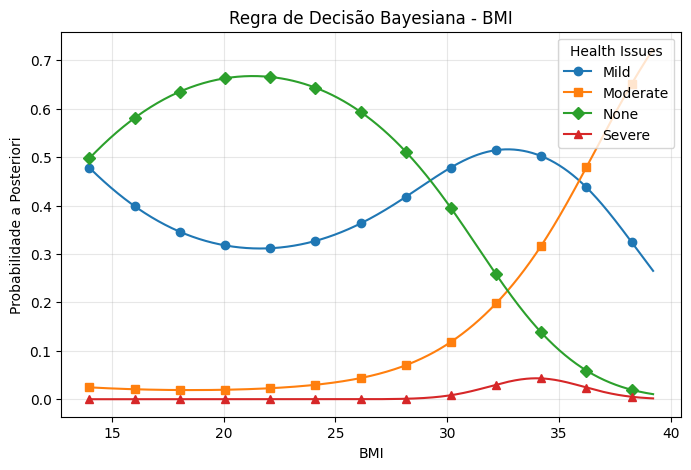

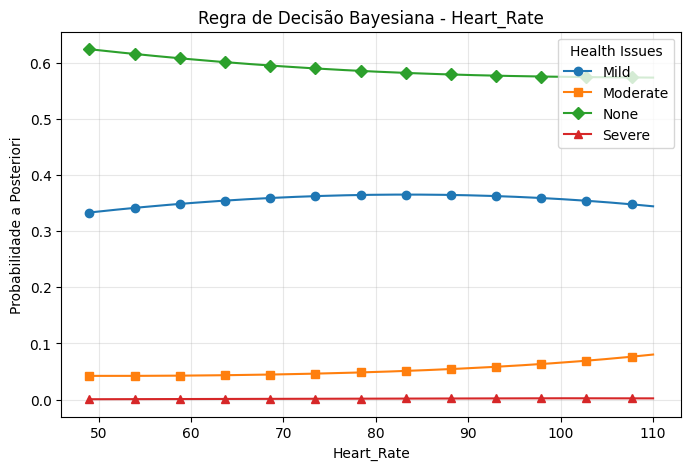

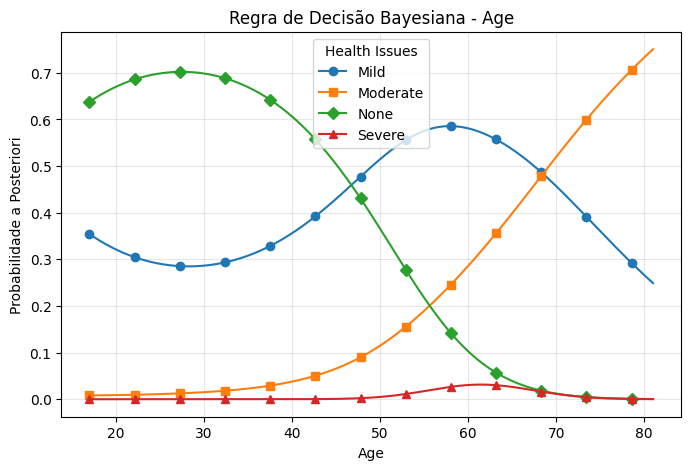

In [11]:
# 2.10 Aplicar Bayes

# Features numéricas escolhidas para aplicar Bayes
features = ['BMI', 'Heart_Rate', 'Age']

# Marcadores para diferenciar as classes
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

# Aplicar regra de decisão Bayesiana para cada feature
for feature in features:
    x = df[[feature]].values
    y = df['Health_Issues'].values

    model = GaussianNB()
    model.fit(x, y)

    x_min, x_max = x.min() - 1, x.max() + 1
    x_vals = np.linspace(x_min, x_max, 500).reshape(-1, 1)

    # Probabilidades a posteriori
    posterior_probs = model.predict_proba(x_vals)

    plt.figure(figsize=(8, 5))
    for i, cls in enumerate(model.classes_):
        marker = markers[i % len(markers)]
        plt.plot(x_vals, posterior_probs[:, i], label=cls, marker=marker, markevery=40)

    plt.title(f'Regra de Decisão Bayesiana - {feature}')
    plt.xlabel(feature)
    plt.ylabel('Probabilidade a Posteriori')
    plt.legend(title='Health Issues')
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
# 2.11  Descrever como a escolha das características (eventos) diferentes modificaram (ou não) os resultados